## Findings -:-

In this use case I tried to investigate how Naive Bayes performs if we use TfidfVectorizer as feature extractor. 



## Import the necessary libraries

In [26]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from bs4 import BeautifulSoup
from collections import defaultdict
import re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Create Training Data

In [2]:
# Training set

ds = tfds.load('imdb_reviews', split='train', as_supervised=True)
#ds = ds.take(1)

training_sentences = []
training_labels = []

for text, label in tfds.as_numpy(ds):
  #print(text.decode('UTF-8'), type(label), label)
  training_sentences.append(text.decode('UTF-8')) #to convert bytes into strings
  training_labels.append(label)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteDOEW30/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteDOEW30/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteDOEW30/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_df = pd.DataFrame(np.column_stack((training_sentences,training_labels)), 
                        columns = ['Sentences', 'Labels'])
train_df.head()

,Sentences,Labels
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [4]:
train_df.shape

(25000, 2)

## Create Validation Data/Test Data

In [5]:
# Validation set
ds = tfds.load('imdb_reviews', split='test', as_supervised=True)
ds = ds.take(10000)

valid_sentences = []
valid_labels = []

for text, label in tfds.as_numpy(ds):
  #print(text.decode('UTF-8'), type(label), label)
  valid_sentences.append(text.decode('UTF-8')) #to convert bytes into strings
  valid_labels.append(label)

valid_df = pd.DataFrame(np.column_stack((valid_sentences,valid_labels)), 
                        columns = ['Sentences', 'Labels'])
valid_df.head()

,Sentences,Labels
0,There are films that make careers. For George ...,1
1,"A blackly comic tale of a down-trodden priest,...",1
2,"Scary Movie 1-4, Epic Movie, Date Movie, Meet ...",0
3,Poor Shirley MacLaine tries hard to lend some ...,0
4,As a former Erasmus student I enjoyed this fil...,1


In [6]:
valid_df.shape

(10000, 2)

## Text preprocessing

### Functions for preprocessing

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
 text = BeautifulSoup(text, "lxml").text # HTML decoding
 text = text.lower() # lowercase text
 text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
 text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
 text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
 return text

def stemming(sentence):
 
 stemmer = PorterStemmer()
 stemmed = [stemmer.stem(word) for word in sentence.split()]
 #stemSentence = stemSentence.strip()
 return ' '.join(stemmed)


# Lemmatizer function
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
lmtzr = WordNetLemmatizer()

def lemmatize(sentence):
  lemmatized_sentence = []
  tokens = word_tokenize(sentence)
  for token, tag in pos_tag(tokens):  # returns token and corresponding tag from list of tokens
    lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
    #print(token, "=>", lemma)
    lemmatized_sentence.append(lemma)
  return ' '.join(lemmatized_sentence)



### Proprocessing Training Senetences



```
tokens = word_tokenize(train_df.loc[0,'Sentences'])

print(pos_tag(tokens))

[('absolutely', 'RB'), ('terrible', 'JJ'), ('movie', 'NN'), ('dont', 'NN'), ('lured', 'VBD'), ('christopher', 'JJR'), ('walken', 'NN'), ('michael', 'NN'), ('ironside', 'VBP'), ('great', 'JJ'), ('actors', 'NNS'), ('must', 'MD'), ('simply', 'RB'), ('worst', 'VB'), ('role', 'NN'), ('history', 'NN'), ('even', 'RB'), ('great', 'JJ'), ('acting', 'VBG'), ('could', 'MD'), ('redeem', 'VB'), ('movies', 'NNS'), ('ridiculous', 'JJ'), ('storyline', 'JJ'), ('movie', 'NN'), ('early', 'JJ'), ('nineties', 'NNS'), ('us', 'PRP'), ('propaganda', 'VBP'), ('piece', 'JJ'), ('pathetic', 'JJ'), ('scenes', 'NNS'), ('columbian', 'JJ'), ('rebels', 'NNS'), ('making', 'VBG'), ('cases', 'NNS'), ('revolutions', 'NNS'), ('maria', 'VBP'), ('conchita', 'JJ'), ('alonso', 'NN'), ('appeared', 'VBD'), ('phony', 'JJ'), ('pseudolove', 'NN'), ('affair', 'NN'), ('walken', 'IN'), ('nothing', 'NN'), ('pathetic', 'JJ'), ('emotional', 'JJ'), ('plug', 'NN'), ('movie', 'NN'), ('devoid', 'JJ'), ('real', 'JJ'), ('meaning', 'NN'), ('disappointed', 'JJ'), ('movies', 'NNS'), ('like', 'IN'), ('ruining', 'VBG'), ('actors', 'NNS'), ('like', 'IN'), ('christopher', 'NN'), ('walkens', 'NNS'), ('good', 'JJ'), ('name', 'NN'), ('could', 'MD'), ('barely', 'RB'), ('sit', 'VB')]
```






In [8]:
train_df['Sentences'] = train_df['Sentences'].apply(lambda x : clean_text(x))
train_df.head()

,Sentences,Labels
0,absolutely terrible movie dont lured christoph...,0
1,known fall asleep films usually due combinatio...,0
2,mann photographs alberta rocky mountains super...,0
3,kind film snowy sunday afternoon rest world go...,1
4,others mentioned women go nude film mostly abs...,1


In [9]:
train_df['Lemmatized'] =  train_df['Sentences'].apply(lambda x : lemmatize(x))
train_df.head(2)

,Sentences,Labels,Lemmatized
0,absolutely terrible movie dont lured christoph...,0,absolutely terrible movie dont lure christophe...
1,known fall asleep films usually due combinatio...,0,know fall asleep film usually due combination ...


In [10]:
train_df['Lemmatized'][0]

'absolutely terrible movie dont lure christopher walken michael ironside great actor must simply worst role history even great act could redeem movie ridiculous storyline movie early ninety u propaganda piece pathetic scene columbian rebel make case revolution maria conchita alonso appear phony pseudolove affair walken nothing pathetic emotional plug movie devoid real meaning disappointed movie like ruin actor like christopher walkens good name could barely sit'

### Proprocessing Validation Senetences

In [11]:
valid_df['Sentences'] = valid_df['Sentences'].apply(lambda x : clean_text(x)) # clean all punctuations, lowercase, remove stopwords
#valid_df['Stemmed']  = valid_df['Sentences'].apply(lambda x : stemming(x)) # Stemming
valid_df['Lemmatized'] =  valid_df['Sentences'].apply(lambda x : lemmatize(x)) # Lemmatization
valid_df.head()

,Sentences,Labels,Lemmatized
0,films make careers george romero night living ...,1,film make career george romero night live dead...
1,blackly comic tale downtrodden priest nazarin ...,1,blackly comic tale downtrodden priest nazarin ...
2,scary movie 14 epic movie date movie meet spar...,0,scary movie 14 epic movie date movie meet spar...
3,poor shirley maclaine tries hard lend gravitas...,0,poor shirley maclaine try hard lend gravitas m...
4,former erasmus student enjoyed film much reali...,1,former erasmus student enjoy film much realist...


## Let's checkout the distributions of target in the training set & dev set and decide the performance metrics

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


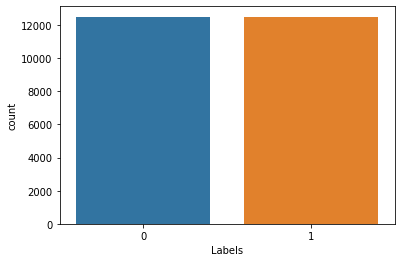

In [12]:
sns.countplot(train_df['Labels'])

In [13]:
train_df['Labels'].value_counts()

0    12500
1    12500
Name: Labels, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


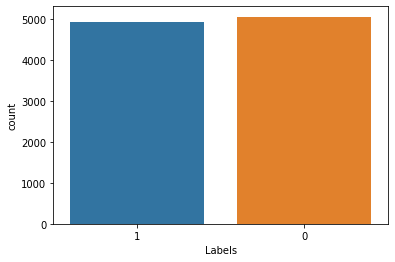

In [14]:
sns.countplot(valid_df['Labels'])

In [15]:
valid_df['Labels'].value_counts()

0    5061
1    4939
Name: Labels, dtype: int64

So, from the above plots we see both labels in training data and test data are quiet balanced. So we can use accuracy score as metrics in this case. But for now, I'll try to use f1-score as performance metric

## Let's create features with sklearn's TFIDFVectorizer 
_We'll try with both lemmatized and stemmed texts to check is there difference in the performace of the model_

### Analysis of tokens in Lemmatized and Stemmed sentences

In [16]:
# Lemmatized sentences
lemma_corpus = [word_tokenize(sentence) for sentence in train_df['Lemmatized']]
lemma_corpus = list(itertools.chain.from_iterable(lemma_corpus)) # to jooin the list of lists
print('Total no. of sentences tokenized:', len(train_df['Lemmatized']))
print('Unique tokens: ',len(set(lemma_corpus)))
print('Total no. of tokens: ',len(lemma_corpus))
print('% of unique tokens: ','{:.3f}'.format(len(set(lemma_corpus))/len(lemma_corpus)*100),' %')

Total no. of sentences tokenized: 25000
Unique tokens:  123767
Total no. of tokens:  3041167
% of unique tokens:  4.070  %


In [17]:
lemma_corpus[:7]

['absolutely', 'terrible', 'movie', 'dont', 'lure', 'christopher', 'walken']

From the above comparison we see that Lemmatization creates more no.of unique tokens than Stemming in this use case. If we see the total count of tokens 

### Let's create the TFI-DF feature vectors

In [20]:
all_training_sentences_lemma = [sentence for sentence in train_df.Lemmatized]
len(all_training_sentences_lemma)

25000

In [29]:
cvector_lemma = TfidfVectorizer(max_features = 30000)
lemma_train_bow = cvector_lemma.fit_transform(all_training_sentences_lemma).toarray()
lemma_train_bow.shape

(25000, 30000)

In [30]:
all_validation_sentences_lemma = [sentence for sentence in valid_df.Lemmatized]
lemma_test_bow = cvector_lemma.transform(all_validation_sentences_lemma)
lemma_test_bow.shape

(10000, 30000)

## Training a Naive Bayes Classifier

### Naive Bayes on Lemmatized Sentences

In [31]:
classifier = MultinomialNB()
classifier.fit(lemma_train_bow,np.array(training_labels))
predicted_labels = classifier.predict(lemma_test_bow)
predicted_labels_train = classifier.predict(lemma_train_bow)

In [32]:
print("Validation Set")
print(classification_report(np.array(valid_labels),predicted_labels))
print("Training Set")
print(classification_report(np.array(training_labels),predicted_labels_train))

Validation Set
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      5061
           1       0.86      0.77      0.81      4939

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Training Set
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     12500
           1       0.91      0.89      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



In [34]:
print(confusion_matrix(np.array(valid_labels),predicted_labels))
print(roc_auc_score(np.array(valid_labels),predicted_labels))

[[4439  622]
 [1117 3822]]
0.8254701229731032
